# Make plots and compute summary stats for Hunger and Justify studies

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf

#r stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex') 

%matplotlib inline

In [ ]:
#set plotting settings
sns.set_context('paper',font_scale = 2.5)
sns.set(font="Times New Roman")
sns.set_style("white")

In [7]:
home_dir = '/home/iballard/Dropbox/Magnitude_fMRI/'
data_dir = '/home/iballard/mag/scripts/behavioral/'

# Hunger

(-0.28767764198930867, 0.00031128558860400875)


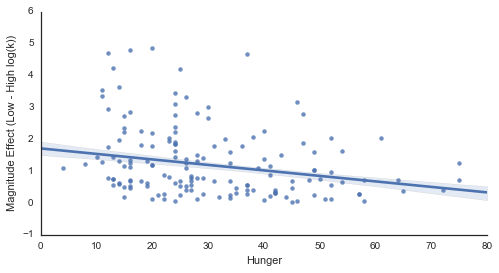

In [8]:
plt.figure(figsize=(8, 4))
hunger = pd.read_csv(data_dir + 'hunger_k_and_m.csv')
hunger = hunger.dropna()
hunger['Hunger'] = hunger['hunger']
hunger['Magnitude Effect (Low - High log(k))'] = [np.log(l) - np.log(h) for h,l in zip(hunger['k_high'],hunger['k_low'])]

ax = sns.regplot(y = 'Magnitude Effect (Low - High log(k))',x = 'Hunger',data = hunger,ci = 68,
                robust = True)
sns.despine()
print scipy.stats.pearsonr(hunger['Magnitude Effect (Low - High log(k))'],np.log(hunger['hunger']))
plt.savefig(home_dir + '/Figures/hunger_mag_corr.svg',dpi=300)

In [32]:
#compute correlations 
scipy.stats.pearsonr(np.log(hunger['m_low']),np.log(hunger['hunger']))

(-0.66689092708083675, 4.9371075316164838e-21)

In [31]:
#compute size of magnitude effect
diff = np.log(hunger['k_high']) - np.log(hunger['k_low'])
print np.sum(diff > 0)
print scipy.stats.ttest_1samp(diff,0)
print np.mean(diff)/np.std(diff)

0
Ttest_1sampResult(statistic=-14.575489448353999, pvalue=1.1523709513930357e-30)
-1.18222830599


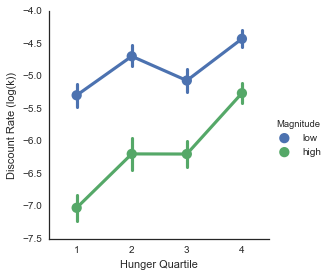

In [18]:
#plot discount rate as a function of magnitude and hunger
plt.figure(figsize=(4, 4))
df = pd.DataFrame()
df['Hunger Quartile'] = map(int,list(hunger['hungerLevel'].values)*2)
df['Discount Rate (log(k))'] = map(np.log,hunger['k_low'].values) + map(np.log,hunger['k_high'].values)
df['Magnitude'] = ['low']*len(hunger['k_low']) + ['high']*len(hunger['k_high'])

sns.factorplot(x="Hunger Quartile", y="Discount Rate (log(k))", hue="Magnitude",data=df,ci=68);

plt.savefig(home_dir + '/Figures/hunger_mag_quartiles.svg',dpi=300)

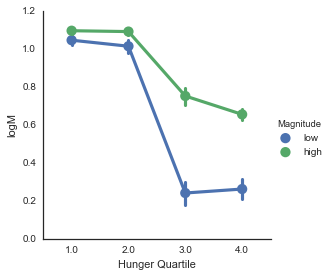

In [19]:
#plot M as a function of magnitude and hunger
plt.figure(figsize=(4, 4))
df = pd.DataFrame()
df['Hunger Quartile'] = list(hunger['hungerLevel'].values)*2
df['logM'] = map(np.log,hunger['m_low'].values) + map(np.log,hunger['m_high'].values)
df['Magnitude'] = ['low']*len(hunger['m_low']) + ['high']*len(hunger['m_high'])
sns.factorplot(x="Hunger Quartile", y="logM", hue="Magnitude", data=df, ci=68);
plt.savefig(home_dir + '/Figures/m_quartiles.svg',dpi=300)

(-0.3514143796987525, 8.4282875820250962e-06)


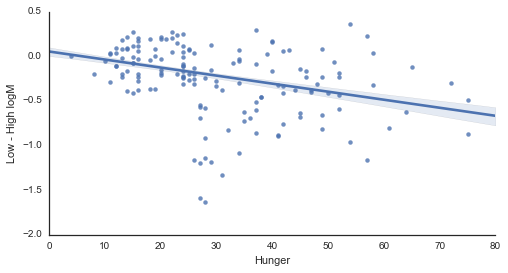

In [20]:
#plot correlation of M magnitude effect with hunger
plt.figure(figsize=(8, 4))

hunger['Low - High logM'] = [np.log(l) - np.log(h) for h,l in zip(hunger['m_high'],hunger['m_low'])]
sns.regplot(y = 'Low - High logM',x = 'Hunger',data = hunger,
            robust = True, ci=68)
sns.despine()
print scipy.stats.pearsonr(hunger['Low - High logM'],np.log(hunger['hunger']))

plt.savefig(home_dir + '/Figures/m_corr.svg',dpi=300)

In [21]:
#ANOVA on magnitude effect with k
df = pd.DataFrame()

for row in hunger.iterrows():
    new_r = {'sub':str(row[0]),
                  'k':np.log(row[1]['k_low']),
                  'mag':'low',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))
    
    new_r = {'sub':str(row[0]),
                  'k':np.log(row[1]['k_high']),
                  'mag':'high',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))

model = afex.aov_ez('sub', 'k', data = df, within=['mag'],between='hunger')
print(model)
print model.rx2('Anova')

Anova Table (Type 3 tests)

Response: k
      Effect     df  MSE          F ges p.value
1     hunger 3, 149 2.13  10.69 *** .15  <.0001
2        mag 1, 149 0.56 231.99 *** .24  <.0001
3 hunger:mag 3, 149 0.56    5.41 ** .02    .001

Sphericity correction method: GG 


Type III Repeated Measures MANOVA Tests: Pillai test statistic
            Df test stat approx F num Df den Df    Pr(>F)    
(Intercept)  1   0.96712   4382.5      1    149 < 2.2e-16 ***
hunger       3   0.17706     10.7      3    149 2.101e-06 ***
mag          1   0.60891    232.0      1    149 < 2.2e-16 ***
hunger:mag   3   0.09824      5.4      3    149  0.001463 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



//anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Converting to factor: hunger

  warnings.warn(x, RRuntimeWarning)
//anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: hunger

  warnings.warn(x, RRuntimeWarning)


In [22]:
#ANOVA on magnitude effect with m
df = pd.DataFrame()

for row in hunger.iterrows():
    new_r = {'sub':str(row[0]),
                  'm':np.log(row[1]['m_low']),
                  'mag':'low',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))
    
    new_r = {'sub':str(row[0]),
                  'm':np.log(row[1]['m_high']),
                  'mag':'high',
                 'hunger':row[1]['hungerLevel']}
    df = df.append(pd.DataFrame.from_dict({0: new_r}, orient='index'))

model = afex.aov_ez('sub', 'm', data = df, within=['mag'],between='hunger')
# lsm  = importr('lsmeans')
# pairwise = lsm.lsmeans(model, "mag", contr="pairwise", adjust="holm")
print model
print model.rx2('Anova')

Anova Table (Type 3 tests)

Response: m
      Effect     df  MSE          F ges p.value
1     hunger 3, 149 0.05 165.32 *** .61  <.0001
2        mag 1, 149 0.06  86.62 *** .23  <.0001
3 hunger:mag 3, 149 0.06  17.14 *** .15  <.0001

Sphericity correction method: GG 


Type III Repeated Measures MANOVA Tests: Pillai test statistic
            Df test stat approx F num Df den Df    Pr(>F)    
(Intercept)  1   0.95836   3429.6      1    149 < 2.2e-16 ***
hunger       3   0.76897    165.3      3    149 < 2.2e-16 ***
mag          1   0.36763     86.6      1    149 < 2.2e-16 ***
hunger:mag   3   0.25653     17.1      3    149 1.295e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



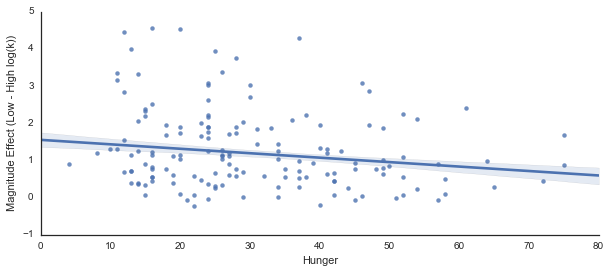

In [23]:
# plot k with mag partialled out
plt.figure(figsize=(10, 4))
ax = sns.regplot(y = 'Magnitude Effect (Low - High log(k))',x = 'Hunger',data = hunger,
                robust = True, y_partial = 'Low - High logM',ci=68)
sns.despine()
plt.savefig(home_dir + '/Figures/hunger_mag_corr_partial.svg',dpi=300)


In [24]:
# Fit regression model of k and m on hunger
hunger['K_low_minus_high'] = hunger['Magnitude Effect (Low - High log(k))']
hunger['M_low_minus_high'] = hunger['Low - High logM']
hunger['logHunger'] = np.log(hunger['hunger'])
results = smf.ols('logHunger ~ K_low_minus_high + M_low_minus_high', data=hunger).fit()

# Inspect the results
print results.summary()

                            OLS Regression Results                            
Dep. Variable:              logHunger   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     14.99
Date:                Mon, 19 Dec 2016   Prob (F-statistic):           1.17e-06
Time:                        11:43:52   Log-Likelihood:                -102.06
No. Observations:                 153   AIC:                             210.1
Df Residuals:                     150   BIC:                             219.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            3.3178      0.071  

In [29]:
#compute partial correlation
results = smf.ols('logHunger ~ M_low_minus_high', data=hunger).fit()
scipy.stats.pearsonr(results.resid, hunger['K_low_minus_high'])

(-0.21477822206705721, 0.0076745857700445006)

# Justify experiment

In [9]:
justify = pd.read_csv(data_dir + 'justify.csv')

In [10]:
#make coding more explicit
cond_map = {'1':20,'2':20,
           '3':50,'4':50,
           '5':100,'6':100,
           '7':200,'8':200,
           '9':2000,'10':2000}
manip_map = {1:'No Justification',2:'Justification'}
justify['Offer'] = [cond_map[str(x)] for x in justify['Condition']]
justify['Condition'] = [manip_map[x] for x in justify['Manipulation']]

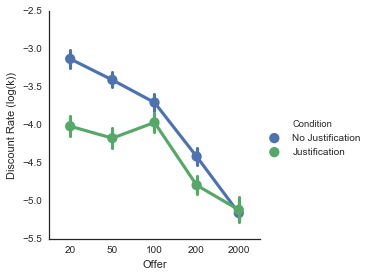

In [20]:
#plot justify results
plt.figure(figsize=(4, 4))
justify['Discount Rate (log(k))'] = map(np.log,(justify['Choice'] / justify['Offer'] - 1)/30.0)
sns.factorplot(x="Offer", y="Discount Rate (log(k))", hue="Condition", data=justify, ci=68);
sns.despine()
plt.savefig(home_dir + '/Figures/justify.svg',dpi=300)

In [82]:
justify['logK'] = justify['Discount Rate (log(k))']
justify['sub'] = justify['Subject ID']
model = afex.aov_ez('sub', 'logK', data = justify, between=['Manipulation','Magnitude'])
print model
print model.rx2('Anova')

Anova Table (Type 3 tests)

Response: logK
                  Effect      df  MSE         F ges p.value
1           Manipulation 1, 1372 2.03 33.88 *** .02  <.0001
2              Magnitude 4, 1372 2.03 57.03 *** .14  <.0001
3 Manipulation:Magnitude 4, 1372 2.03  4.68 *** .01   .0009

Anova Table (Type III tests)

Response: dv
                        Sum Sq   Df   F value    Pr(>F)    
(Intercept)            23760.0    1 11693.858 < 2.2e-16 ***
Manipulation              68.8    1    33.882 7.283e-09 ***
Magnitude                463.5    4    57.030 < 2.2e-16 ***
Manipulation:Magnitude    38.0    4     4.678 0.0009421 ***
Residuals               2787.7 1372                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

